In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def initialize_grid(size, num_live_cells):
    grid = np.zeros(size)
    for _ in range(num_live_cells):
        x, y = np.random.randint(0, size[0]), np.random.randint(0, size[1])
        grid[x, y] = 1
    return grid

def update_grid(grid):
    new_grid = grid.copy()
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            live_neighbors = np.sum(grid[i-1:i+2, j-1:j+2]) - grid[i, j]
            if grid[i, j] == 1 and (live_neighbors < 2 or live_neighbors > 3):
                new_grid[i, j] = 0  # Cell dies
            elif grid[i, j] == 0 and live_neighbors == 3:
                new_grid[i, j] = 1  # Cell becomes alive
    return new_grid

def run_simulation(size=(50, 50), num_live_cells=100, steps=100):
    grid = initialize_grid(size, num_live_cells)
    data = [grid.copy()]

    for _ in range(steps):
        grid = update_grid(grid)
        data.append(grid.copy())

    return data

# Example usage
data = run_simulation()

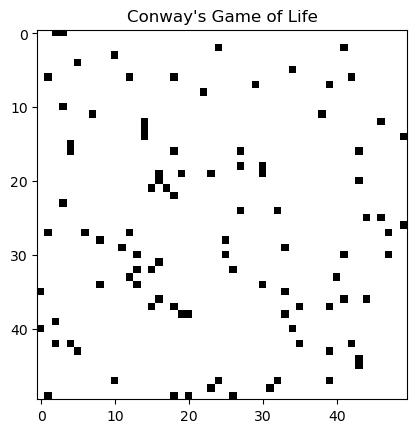

/opt/anaconda3/envs/conways/lib/python3.11/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def animate(data):
    fig, ax = plt.subplots()
    ax.set_title("Conway's Game of Life")
    img = ax.imshow(data[0], cmap='binary')

    def update(frame):
        img.set_array(data[frame])
        return img,

    ani = animation.FuncAnimation(fig, update, frames=len(data), interval=100)
    plt.show()

animate(data)

In [4]:
 # Save as .npy file
np.save('game_of_life_data.npy', data) 
